<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/APPLE_WINDOWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning - ENSAE 2020** 

## **Cycle-GANs application** : from MNIST to USPS 

In this notebook we undertake an Image-to-Image translation using the Cycle-GANs architecture. The first section uses a simple architecture proposed in the Cycle-GAN introductory [paper](https://arxiv.org/pdf/1703.10593.pdf) and its Pytorch implementation in the following [github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). The task is to translate from USPS to MNIST. Section 2 proposes improvements based on [(Martin Arjovsky et al., 2017)]() and computes a Wasserstein Cycle-GAN on the same task.

This code is adapted from [yunjey](https://github.com/yunjey/) and the assignment proposed. 

#### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
from torchvision import datasets, models, transforms
import os 
from six.moves.urllib.request import urlretrieve
import tarfile
import warnings
warnings.filterwarnings("ignore")

### **Preparing the data** 

In [0]:
PATH_DATA = './data/'
RESULTS_PATH = './results/'

In [0]:
os.makedirs(PATH_DATA, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size = 32
batch_size = 64
num_workers = 0
n_iters = 10000

#### Download and construct loaders for USPS and Mnist

In [0]:
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):

    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(data_dir, fname)
    
    print(fpath)

    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {} : {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
            return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [7]:
data_fpath = get_file(fname='emojis', 
                      origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                      untar=True,
                      cache_dir=PATH_DATA)

./data/emojis.tar.gz


In [0]:
def get_emoji_loader(emoji_type, image_size, batch_size, num_workers):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    img_path = os.path.join('data/emojis', emoji_type)

    dataset = datasets.ImageFolder(img_path, transform)

    dloader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

    return dloader

In [0]:
def get_emoji_loader_test(emoji_type, image_size, batch_size, num_workers):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    img_path = os.path.join('data/emojis', emoji_type)

    dataset = datasets.ImageFolder(img_path, transform)

    dloader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)

    return dloader

In [0]:
dataloader_apple = get_emoji_loader("Apple", image_size, batch_size, num_workers)
dataloader_apple_test = get_emoji_loader_test("Test_Apple", image_size, batch_size, num_workers)
dataloader_win = get_emoji_loader("Windows", image_size, batch_size, num_workers)
dataloader_win_test = get_emoji_loader_test("Test_Windows", image_size, batch_size, num_workers)

In [0]:
examples_apple = iter(dataloader_apple)
example_data_apple, _ = next(examples_apple)

examples_win = iter(dataloader_win)
example_data_win, _ = next(examples_win)

In [11]:
example_data_apple.shape, example_data_win.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 3, 32, 32]))

#### Visualizing both collections

In [0]:
import matplotlib.pyplot as plt

Apple emojis Collection :


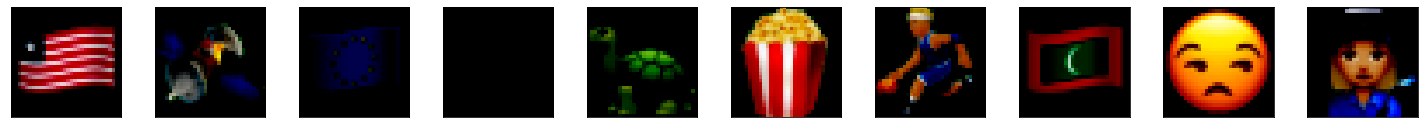

In [13]:
print("Apple emojis Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    np_img = np.transpose(example_data_apple[i].numpy(), (1, 2, 0))
    plt.imshow(np.clip(np_img, 0, 1), interpolation='none')
    plt.xticks([])
    plt.yticks([])

Windows emojis Collection :


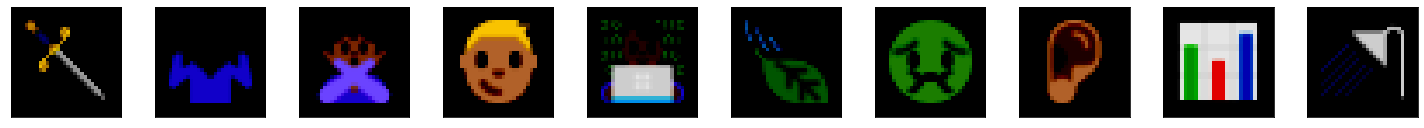

In [14]:
print("Windows emojis Collection :")

fig = plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    np_img = np.transpose(example_data_win[i].numpy(), (1, 2, 0))
    plt.imshow(np.clip(np_img, 0, 1), interpolation='none')
    plt.xticks([])
    plt.yticks([])

The USPS dataset consists of 7,291 training images and 2007 test images each of which is of the original size of 16x16. The MNIST dataset consists of 60 000 training images and 10 000 test images each of which is of the size 28x28. Both contains 10 categories (numbers from 0 to 9) and follow distinct distributions. 

### **Model Construction**

Some helper functions

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [0]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

**Discriminator**

The discriminator takes images and tries to predict if it is real of if it is fake. In this case the discriminator is just a network that search for features in the input. 

The network consist in a serie of convolutional layer. 

In [0]:
class D_(nn.Module):
    """Discriminator for mnist."""

    def __init__(self, conv_dim=64, sigmoid_end=True):
        super(D_, self).__init__()
        self.sigmoid_end = sigmoid_end
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)   
        out = F.leaky_relu(self.conv2(out), 0.05) 
        out = F.leaky_relu(self.conv3(out), 0.05)  
        out = self.fc(out).squeeze()
        if self.sigmoid_end:
          out=torch.sigmoid(out)
        return out

In [20]:
D_A = D_()
D_A.cuda() # This is our discriminator architecture

D_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

An example of one batch passing through the Discriminator

In [0]:
images_apple, _ = iter(dataloader_apple).next()
images_apple = to_var(images_apple)

In [22]:
print("Discriminator's output size : {}".format(D_A(images_apple).size()))

Discriminator's output size : torch.Size([64])


In [23]:
print("Discriminator's output overview :")
D_A(images_apple)

Discriminator's output overview :


tensor([0.2744, 0.3654, 0.3268, 0.1758, 0.4237, 0.3159, 0.3027, 0.3723, 0.1962,
        0.3170, 0.4256, 0.3383, 0.4141, 0.3183, 0.4185, 0.3542, 0.3146, 0.3068,
        0.3016, 0.3358, 0.2563, 0.3238, 0.3615, 0.2313, 0.2474, 0.4455, 0.2354,
        0.3063, 0.3372, 0.3967, 0.4536, 0.1691, 0.2416, 0.2402, 0.4089, 0.4075,
        0.2628, 0.3244, 0.3438, 0.3562, 0.1749, 0.3435, 0.3468, 0.3628, 0.3071,
        0.3106, 0.2024, 0.3260, 0.3129, 0.4328, 0.2459, 0.3002, 0.2479, 0.3859,
        0.2052, 0.3347, 0.2967, 0.2865, 0.2906, 0.3953, 0.2235, 0.2862, 0.3932,
        0.3119], device='cuda:0', grad_fn=<SigmoidBackward>)

#### Creating generators 

The Generator contains 3 relevants parts : 


1.   Encoding blocks : A convolution network that extract features from the input image 

2.   Residual blocks : 

3.   Decoding blocks : deconvolution layes work back the low-level features 






In [0]:
class G_(nn.Module):
    """Generator for transfering from mnist to usps"""
    
    def __init__(self, conv_dim=64):
        super(G_, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out


In [25]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_().parameters())
print("Number of parameters in the Generator's Network : {}".format(pytorch_total_params))

Number of parameters in the Generator's Network : 564224


#### Utility functions

In [0]:
def print_models(G_AtoW, G_WtoA, D_A, D_W):
    """Prints model information for the generators and discriminators.
    """
    
    print("                 G_AtoW                ")
    print("---------------------------------------")
    print(G_AtoW)
    print("---------------------------------------")

    print("                 G_WtoA                ")
    print("---------------------------------------")
    print(G_WtoA)
    print("---------------------------------------")

    print("                  D_A                  ")
    print("---------------------------------------")
    print(D_A)
    print("---------------------------------------")

    print("                  D_W                  ")
    print("---------------------------------------")
    print(D_W)
    print("---------------------------------------")

In [0]:
def weights_init(m):
    """Initialization of model weights and biases
    """

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
def create_model():
    """Instantiate models, initialize their parameters,
    display their architecture, and send them to the GPU if available.
    """

    G_AtoW = G_().apply(weights_init)
    G_WtoA = G_().apply(weights_init)
    D_A = D_().apply(weights_init)
    D_W = D_().apply(weights_init)

    print_models(G_AtoW, G_WtoA, D_A, D_W)

    if torch.cuda.is_available():
        G_AtoW.cuda()
        G_WtoA.cuda()
        D_A.cuda()
        D_W.cuda()
        print('Models moved to GPU.')

    return G_AtoW, G_WtoA, D_W, D_A

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """

    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3

    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
        
    return merged.transpose(1, 2, 0)

In [0]:
def save_samples(iteration, fixed_W, fixed_A, G_WtoA, G_AtoW, opt_name=''):
    """Saves samples from both generators A->W and W->A.
    """

    import os
    import imageio
    fake_A = G_WtoA(fixed_W)
    fake_W = G_AtoW(fixed_A)

    A, fake_A = to_data(fixed_A), to_data(fake_A)
    W, fake_W = to_data(fixed_W), to_data(fake_W)

    merged = merge_images(A, fake_W)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-A-W'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(W, fake_A)
    path = os.path.join(RESULTS_PATH,
                        'sample-{:06d}-W-A'.format(iteration) + opt_name + '.png')
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

#### Training loop

In [31]:
G_AtoW, G_WtoA, D_A, D_W = create_model()

                 G_AtoW                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Within the training loop, we train the GAN loss $\mathcal{L}_{\mathrm{GAN}}(G, D, X, Y)$ in the following way: 
   
1 - the **Discriminator** $D$ to minimize $\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[(D(G(x))-1)^{2}\right]$  
  
2 - the **Generator** $G$ to minimize $\mathbb{E}_{y \sim p_{\text {data }}(y)}\left[(D(y)-1)^{2}\right] + \mathbb{E}_{x \sim p_{\text {data }}(x)}\left[D(G(x))^{2}\right]$

In [0]:
def training_loop(A_train_loader, W_train_loader, A_test_loader, W_test_loader,
                  sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                  batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                  opt_name=''):
    
    dict_result = {}
    dict_result['d_real_loss'] = []
    dict_result['D_W_loss'] = []
    dict_result['D_A_loss'] = []
    dict_result['d_fake_loss'] = []
    dict_result['g_loss'] = []

    # Create Generators and Discriminators
    G_AtoW, G_WtoA, D_A, D_W = create_model()

    # Get Generator parameters
    g_params = list(G_AtoW.parameters()) + list(G_WtoA.parameters())
    # Get Discriminator parameters
    d_params = list(D_A.parameters()) + list(D_W.parameters())  

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.Adam(g_params, lr)
    d_optimizer = optim.Adam(d_params, lr)

    iter_A = iter(A_train_loader)
    iter_W = iter(W_train_loader)

    test_iter_A = iter(A_test_loader)
    test_iter_W = iter(W_test_loader)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixeD_A = to_var(test_iter_A.next()[0])
    fixeD_W = to_var(test_iter_W.next()[0])

    # Datasets don's have the same length, we choose the smaller one to drive the
    # number of iterations per epoch
    iter_per_epoch = min(len(iter_A), len(iter_W))



    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_A = iter(A_train_loader)
            iter_W = iter(W_train_loader)

        images_A, _ = iter_A.next()
        images_A = to_var(images_A)

        images_W, _ = iter_W.next()
        images_W = to_var(images_W)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ### Train with real images
        d_optimizer.zero_grad()

        # Compute the Discriminator's losses on real images
        out_A = D_A(images_A) # Discriminator MNIST true
        D_A_loss = torch.mean((out_A-1)**2) 

        out_W = D_W(images_W) # Discriminator USPS true
        D_W_loss = torch.mean((out_W-1)**2)

        d_real_loss = D_A_loss + D_W_loss
        d_real_loss.backward()
        d_optimizer.step()


        ### Train with fake images
        d_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images in domain USPS
        fake_A = G_WtoA(images_W)

        # Compute the loss for D_A
        out_A = D_A(fake_A)
        D_A_loss = torch.mean(out_A**2) 

        # Generate fake images that look like domain U based on real images in domain M
        fake_W = G_AtoW(images_A)

        # Compute the loss for D_W
        out_W = D_W(fake_W)
        D_W_loss = torch.mean((out_W)**2) 

        d_fake_loss = D_A_loss + D_W_loss
        d_fake_loss.backward()
        d_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ## USPS--MNIST-->USPS 

        g_optimizer.zero_grad()

        # Generate fake images that look like domain MNIST based on real images
        # in domain USPS
        fake_A = G_WtoA(images_W)
        out = D_A(fake_A)

        # Compute the generator loss based on domain MNIST
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructeD_W = G_AtoW(fake_A)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_W - reconstructeD_W)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


        ## MNIST--USPS-->MNIST 

        g_optimizer.zero_grad()

        # Generate fake images that look like domain USPS based on real images 
        # in domain MNIST
        fake_W = G_AtoW(images_A)
        out = D_W(fake_W)

        # Compute the generator loss based on domain USPS
        g_loss = torch.mean((out-1)**2)

        if use_cycle_consistency_loss:
            reconstructeD_A = G_WtoA(fake_W)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_A - reconstructeD_A)**2)
            g_loss += cyc_lambda * cycle_consistency_loss

        g_loss.backward()
        g_optimizer.step()


        # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | D_W_loss: {:6.4f} | D_A_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), D_W_loss.item(),
                    D_A_loss.item(), d_fake_loss.item(), g_loss.item()))

        dict_result['d_real_loss'].append(float(to_data(d_real_loss)))
        dict_result['D_W_loss'].append(float(to_data(D_W_loss)))
        dict_result['D_A_loss'].append(float(to_data(D_A_loss)))
        dict_result['d_fake_loss'].append(float(to_data(d_fake_loss)))
        dict_result['g_loss'].append(float(to_data(g_loss)))

        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixeD_W, fixeD_A, G_WtoA, G_AtoW, opt_name=opt_name)
        
    return dict_result

Traning with `use_cycle_consistency_loss = True`.

In [33]:
APPLE_WIN = training_loop(dataloader_apple, dataloader_win, dataloader_apple_test, dataloader_win_test,
                           sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step = 100,
                           use_cycle_consistency_loss=True, cyc_lambda=1)

                 G_AtoW                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/10000] | d_real_loss: 0.0403 | D_W_loss: 0.0016 | D_A_loss: 0.0485 | d_fake_loss: 0.0501 | g_loss: 1.1045
Saved ./results/sample-001000-A-W.png
Saved ./results/sample-001000-W-A.png
Iteration [ 1100/10000] | d_real_loss: 0.1147 | D_W_loss: 0.0020 | D_A_loss: 0.0320 | d_fake_loss: 0.0340 | g_loss: 1.0676
Iteration [ 1200/10000] | d_real_loss: 0.0211 | D_W_loss: 0.0063 | D_A_loss: 0.0356 | d_fake_loss: 0.0419 | g_loss: 1.0652
Iteration [ 1300/10000] | d_real_loss: 0.0425 | D_W_loss: 0.2393 | D_A_loss: 0.1450 | d_fake_loss: 0.3843 | g_loss: 0.9563
Iteration [ 1400/10000] | d_real_loss: 0.0122 | D_W_loss: 0.0061 | D_A_loss: 0.0210 | d_fake_loss: 0.0271 | g_loss: 1.0805
Iteration [ 1500/10000] | d_real_loss: 0.0499 | D_W_loss: 0.0126 | D_A_loss: 0.0218 | d_fake_loss: 0.0344 | g_loss: 1.0721
Iteration [ 1600/10000] | d_real_loss: 0.0186 | D_W_loss: 0.0512 | D_A_loss: 0.0125 | d_fake_loss: 0.0637 | g_loss: 0.9706
Iteration [ 1700/10000] | d_real_loss: 0.1136 | D_W_loss: 0.007

Iteration [ 2000/10000] | d_real_loss: 0.1273 | D_W_loss: 0.0052 | D_A_loss: 0.0109 | d_fake_loss: 0.0161 | g_loss: 1.0455
Saved ./results/sample-002000-A-W.png
Saved ./results/sample-002000-W-A.png
Iteration [ 2100/10000] | d_real_loss: 0.0066 | D_W_loss: 0.0831 | D_A_loss: 0.0344 | d_fake_loss: 0.1175 | g_loss: 0.9345
Iteration [ 2200/10000] | d_real_loss: 0.0442 | D_W_loss: 0.0059 | D_A_loss: 0.0176 | d_fake_loss: 0.0235 | g_loss: 1.0424
Iteration [ 2300/10000] | d_real_loss: 0.0278 | D_W_loss: 0.0229 | D_A_loss: 0.0418 | d_fake_loss: 0.0647 | g_loss: 0.9784
Iteration [ 2400/10000] | d_real_loss: 0.0300 | D_W_loss: 0.0016 | D_A_loss: 0.0058 | d_fake_loss: 0.0074 | g_loss: 1.0604
Iteration [ 2500/10000] | d_real_loss: 0.0253 | D_W_loss: 0.0599 | D_A_loss: 0.0328 | d_fake_loss: 0.0928 | g_loss: 0.9577
Iteration [ 2600/10000] | d_real_loss: 0.0535 | D_W_loss: 0.0047 | D_A_loss: 0.0042 | d_fake_loss: 0.0089 | g_loss: 1.0488
Iteration [ 2700/10000] | d_real_loss: 0.0432 | D_W_loss: 0.016

Iteration [ 3000/10000] | d_real_loss: 0.0437 | D_W_loss: 0.0123 | D_A_loss: 0.0194 | d_fake_loss: 0.0317 | g_loss: 1.0101
Saved ./results/sample-003000-A-W.png
Saved ./results/sample-003000-W-A.png
Iteration [ 3100/10000] | d_real_loss: 0.0040 | D_W_loss: 0.0271 | D_A_loss: 0.0215 | d_fake_loss: 0.0486 | g_loss: 0.9272
Iteration [ 3200/10000] | d_real_loss: 0.0061 | D_W_loss: 0.0006 | D_A_loss: 0.0376 | d_fake_loss: 0.0382 | g_loss: 1.0561
Iteration [ 3300/10000] | d_real_loss: 0.0099 | D_W_loss: 0.0024 | D_A_loss: 0.0405 | d_fake_loss: 0.0430 | g_loss: 1.0677
Iteration [ 3400/10000] | d_real_loss: 0.4676 | D_W_loss: 0.0196 | D_A_loss: 0.0309 | d_fake_loss: 0.0506 | g_loss: 0.7730
Iteration [ 3500/10000] | d_real_loss: 0.0685 | D_W_loss: 0.0047 | D_A_loss: 0.0296 | d_fake_loss: 0.0343 | g_loss: 1.0245
Iteration [ 3600/10000] | d_real_loss: 0.0670 | D_W_loss: 0.0268 | D_A_loss: 0.0055 | d_fake_loss: 0.0323 | g_loss: 0.9588
Iteration [ 3700/10000] | d_real_loss: 0.0046 | D_W_loss: 0.002

Iteration [ 4000/10000] | d_real_loss: 0.0195 | D_W_loss: 0.0353 | D_A_loss: 0.0015 | d_fake_loss: 0.0368 | g_loss: 0.9463
Saved ./results/sample-004000-A-W.png
Saved ./results/sample-004000-W-A.png
Iteration [ 4100/10000] | d_real_loss: 0.0161 | D_W_loss: 0.0463 | D_A_loss: 0.0145 | d_fake_loss: 0.0608 | g_loss: 0.9336
Iteration [ 4200/10000] | d_real_loss: 0.0153 | D_W_loss: 0.0008 | D_A_loss: 0.0146 | d_fake_loss: 0.0155 | g_loss: 1.0412
Iteration [ 4300/10000] | d_real_loss: 0.0169 | D_W_loss: 0.0024 | D_A_loss: 0.0047 | d_fake_loss: 0.0071 | g_loss: 1.0222
Iteration [ 4400/10000] | d_real_loss: 0.0268 | D_W_loss: 0.0017 | D_A_loss: 0.0320 | d_fake_loss: 0.0337 | g_loss: 1.0024
Iteration [ 4500/10000] | d_real_loss: 0.0272 | D_W_loss: 0.0014 | D_A_loss: 0.0006 | d_fake_loss: 0.0020 | g_loss: 1.0522
Iteration [ 4600/10000] | d_real_loss: 0.0031 | D_W_loss: 0.0005 | D_A_loss: 0.0188 | d_fake_loss: 0.0194 | g_loss: 1.0561
Iteration [ 4700/10000] | d_real_loss: 0.0282 | D_W_loss: 0.008

Iteration [ 5000/10000] | d_real_loss: 0.0667 | D_W_loss: 0.0006 | D_A_loss: 0.0077 | d_fake_loss: 0.0083 | g_loss: 1.0334
Saved ./results/sample-005000-A-W.png
Saved ./results/sample-005000-W-A.png
Iteration [ 5100/10000] | d_real_loss: 0.0859 | D_W_loss: 0.0025 | D_A_loss: 0.0570 | d_fake_loss: 0.0595 | g_loss: 1.0154
Iteration [ 5200/10000] | d_real_loss: 0.0295 | D_W_loss: 0.0041 | D_A_loss: 0.0011 | d_fake_loss: 0.0052 | g_loss: 1.0029
Iteration [ 5300/10000] | d_real_loss: 0.0071 | D_W_loss: 0.0014 | D_A_loss: 0.0093 | d_fake_loss: 0.0108 | g_loss: 1.0337
Iteration [ 5400/10000] | d_real_loss: 0.0094 | D_W_loss: 0.0009 | D_A_loss: 0.0007 | d_fake_loss: 0.0016 | g_loss: 1.0491
Iteration [ 5500/10000] | d_real_loss: 0.0187 | D_W_loss: 0.0023 | D_A_loss: 0.0024 | d_fake_loss: 0.0047 | g_loss: 1.0421
Iteration [ 5600/10000] | d_real_loss: 0.0076 | D_W_loss: 0.0010 | D_A_loss: 0.0008 | d_fake_loss: 0.0018 | g_loss: 1.0437
Iteration [ 5700/10000] | d_real_loss: 0.0019 | D_W_loss: 0.000

Iteration [ 6000/10000] | d_real_loss: 0.0014 | D_W_loss: 0.0031 | D_A_loss: 0.0013 | d_fake_loss: 0.0043 | g_loss: 1.0364
Saved ./results/sample-006000-A-W.png
Saved ./results/sample-006000-W-A.png
Iteration [ 6100/10000] | d_real_loss: 0.0157 | D_W_loss: 0.0020 | D_A_loss: 0.0233 | d_fake_loss: 0.0253 | g_loss: 1.0188
Iteration [ 6200/10000] | d_real_loss: 0.0020 | D_W_loss: 0.0181 | D_A_loss: 0.0082 | d_fake_loss: 0.0263 | g_loss: 1.0391
Iteration [ 6300/10000] | d_real_loss: 0.0088 | D_W_loss: 0.0007 | D_A_loss: 0.0017 | d_fake_loss: 0.0024 | g_loss: 1.0424
Iteration [ 6400/10000] | d_real_loss: 0.0188 | D_W_loss: 0.0020 | D_A_loss: 0.0139 | d_fake_loss: 0.0159 | g_loss: 1.0255
Iteration [ 6500/10000] | d_real_loss: 0.0028 | D_W_loss: 0.0078 | D_A_loss: 0.0081 | d_fake_loss: 0.0159 | g_loss: 0.9572
Iteration [ 6600/10000] | d_real_loss: 0.0272 | D_W_loss: 0.0003 | D_A_loss: 0.0052 | d_fake_loss: 0.0056 | g_loss: 1.0480
Iteration [ 6700/10000] | d_real_loss: 0.0105 | D_W_loss: 0.009

Iteration [ 7000/10000] | d_real_loss: 0.0014 | D_W_loss: 0.0053 | D_A_loss: 0.0003 | d_fake_loss: 0.0056 | g_loss: 1.0203
Saved ./results/sample-007000-A-W.png
Saved ./results/sample-007000-W-A.png
Iteration [ 7100/10000] | d_real_loss: 0.0180 | D_W_loss: 0.0320 | D_A_loss: 0.0006 | d_fake_loss: 0.0326 | g_loss: 0.9379
Iteration [ 7200/10000] | d_real_loss: 0.0148 | D_W_loss: 0.0052 | D_A_loss: 0.0035 | d_fake_loss: 0.0087 | g_loss: 1.0464
Iteration [ 7300/10000] | d_real_loss: 0.0732 | D_W_loss: 0.0190 | D_A_loss: 0.0007 | d_fake_loss: 0.0197 | g_loss: 0.9917
Iteration [ 7400/10000] | d_real_loss: 0.0010 | D_W_loss: 0.0072 | D_A_loss: 0.0043 | d_fake_loss: 0.0115 | g_loss: 1.0160
Iteration [ 7500/10000] | d_real_loss: 0.0008 | D_W_loss: 0.0030 | D_A_loss: 0.0092 | d_fake_loss: 0.0123 | g_loss: 1.0283
Iteration [ 7600/10000] | d_real_loss: 0.0082 | D_W_loss: 0.0008 | D_A_loss: 0.0103 | d_fake_loss: 0.0111 | g_loss: 1.0434
Iteration [ 7700/10000] | d_real_loss: 0.0136 | D_W_loss: 0.000

Iteration [ 8000/10000] | d_real_loss: 0.0006 | D_W_loss: 0.0219 | D_A_loss: 0.0169 | d_fake_loss: 0.0388 | g_loss: 0.9830
Saved ./results/sample-008000-A-W.png
Saved ./results/sample-008000-W-A.png
Iteration [ 8100/10000] | d_real_loss: 0.0140 | D_W_loss: 0.0016 | D_A_loss: 0.0021 | d_fake_loss: 0.0036 | g_loss: 1.0317
Iteration [ 8200/10000] | d_real_loss: 0.0017 | D_W_loss: 0.0151 | D_A_loss: 0.0160 | d_fake_loss: 0.0311 | g_loss: 1.0049
Iteration [ 8300/10000] | d_real_loss: 0.0275 | D_W_loss: 0.0071 | D_A_loss: 0.0016 | d_fake_loss: 0.0087 | g_loss: 1.0068
Iteration [ 8400/10000] | d_real_loss: 0.0023 | D_W_loss: 0.0009 | D_A_loss: 0.0024 | d_fake_loss: 0.0032 | g_loss: 1.0421
Iteration [ 8500/10000] | d_real_loss: 0.0115 | D_W_loss: 0.0060 | D_A_loss: 0.0022 | d_fake_loss: 0.0082 | g_loss: 1.0524
Iteration [ 8600/10000] | d_real_loss: 0.0035 | D_W_loss: 0.0065 | D_A_loss: 0.0540 | d_fake_loss: 0.0605 | g_loss: 0.9929
Iteration [ 8700/10000] | d_real_loss: 0.0051 | D_W_loss: 0.007

Iteration [ 9000/10000] | d_real_loss: 0.0018 | D_W_loss: 0.0049 | D_A_loss: 0.0025 | d_fake_loss: 0.0073 | g_loss: 0.9864
Saved ./results/sample-009000-A-W.png
Saved ./results/sample-009000-W-A.png
Iteration [ 9100/10000] | d_real_loss: 0.0003 | D_W_loss: 0.0123 | D_A_loss: 0.0492 | d_fake_loss: 0.0615 | g_loss: 0.9998
Iteration [ 9200/10000] | d_real_loss: 0.0290 | D_W_loss: 0.0001 | D_A_loss: 0.0016 | d_fake_loss: 0.0017 | g_loss: 1.0587
Iteration [ 9300/10000] | d_real_loss: 0.0029 | D_W_loss: 0.0024 | D_A_loss: 0.0006 | d_fake_loss: 0.0030 | g_loss: 1.0528
Iteration [ 9400/10000] | d_real_loss: 0.0009 | D_W_loss: 0.0086 | D_A_loss: 0.0047 | d_fake_loss: 0.0133 | g_loss: 0.9966
Iteration [ 9500/10000] | d_real_loss: 0.0174 | D_W_loss: 0.0029 | D_A_loss: 0.0001 | d_fake_loss: 0.0030 | g_loss: 1.0406
Iteration [ 9600/10000] | d_real_loss: 0.0119 | D_W_loss: 0.0008 | D_A_loss: 0.0019 | d_fake_loss: 0.0028 | g_loss: 1.0345
Iteration [ 9700/10000] | d_real_loss: 0.0005 | D_W_loss: 0.050

Iteration [10000/10000] | d_real_loss: 0.0144 | D_W_loss: 0.0040 | D_A_loss: 0.0020 | d_fake_loss: 0.0060 | g_loss: 1.0136
Saved ./results/sample-010000-A-W.png
Saved ./results/sample-010000-W-A.png


Results :

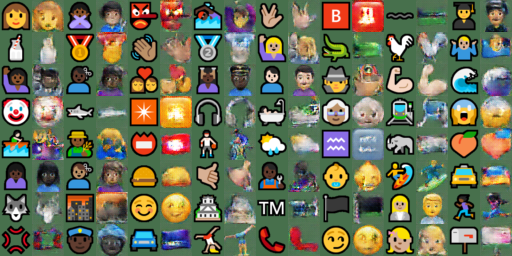

In [34]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-W-A'.format(n_iters) + '.png'))
image

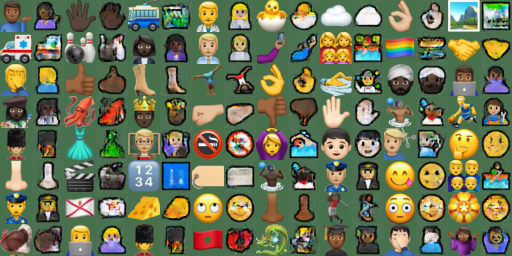

In [35]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-A-W'.format(n_iters) + '.png'))
image

Traning with `use_cycle_consistency_loss = False`.

In [36]:
APPLE_WIN_no_cycle = training_loop(dataloader_apple, dataloader_win, dataloader_apple_test, dataloader_win_test,
                           sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step = 100,
                           use_cycle_consistency_loss=False, opt_name='_no_cycle')

                 G_AtoW                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/10000] | d_real_loss: 0.0612 | D_W_loss: 0.0086 | D_A_loss: 0.0020 | d_fake_loss: 0.0106 | g_loss: 0.9140
Saved ./results/sample-001000-A-W_no_cycle.png
Saved ./results/sample-001000-W-A_no_cycle.png
Iteration [ 1100/10000] | d_real_loss: 0.0119 | D_W_loss: 0.0062 | D_A_loss: 0.0142 | d_fake_loss: 0.0203 | g_loss: 0.9378
Iteration [ 1200/10000] | d_real_loss: 0.0025 | D_W_loss: 0.0107 | D_A_loss: 0.0167 | d_fake_loss: 0.0274 | g_loss: 0.9452
Iteration [ 1300/10000] | d_real_loss: 0.0079 | D_W_loss: 0.0000 | D_A_loss: 0.0416 | d_fake_loss: 0.0416 | g_loss: 0.9979
Iteration [ 1400/10000] | d_real_loss: 0.0415 | D_W_loss: 0.0042 | D_A_loss: 0.0139 | d_fake_loss: 0.0181 | g_loss: 0.9233
Iteration [ 1500/10000] | d_real_loss: 0.0295 | D_W_loss: 0.0237 | D_A_loss: 0.0086 | d_fake_loss: 0.0324 | g_loss: 0.8978
Iteration [ 1600/10000] | d_real_loss: 0.0231 | D_W_loss: 0.0000 | D_A_loss: 0.0080 | d_fake_loss: 0.0081 | g_loss: 0.9955
Iteration [ 1700/10000] | d_real_loss: 0.0500

Iteration [ 2000/10000] | d_real_loss: 0.0576 | D_W_loss: 0.0017 | D_A_loss: 0.0325 | d_fake_loss: 0.0341 | g_loss: 0.9483
Saved ./results/sample-002000-A-W_no_cycle.png
Saved ./results/sample-002000-W-A_no_cycle.png
Iteration [ 2100/10000] | d_real_loss: 0.0776 | D_W_loss: 0.0157 | D_A_loss: 0.0649 | d_fake_loss: 0.0806 | g_loss: 0.8839
Iteration [ 2200/10000] | d_real_loss: 0.0555 | D_W_loss: 0.0104 | D_A_loss: 0.0059 | d_fake_loss: 0.0164 | g_loss: 0.9152
Iteration [ 2300/10000] | d_real_loss: 0.0555 | D_W_loss: 0.0469 | D_A_loss: 0.0126 | d_fake_loss: 0.0594 | g_loss: 0.8536
Iteration [ 2400/10000] | d_real_loss: 0.1178 | D_W_loss: 0.0407 | D_A_loss: 0.0191 | d_fake_loss: 0.0598 | g_loss: 0.8077
Iteration [ 2500/10000] | d_real_loss: 0.0696 | D_W_loss: 0.0382 | D_A_loss: 0.0112 | d_fake_loss: 0.0494 | g_loss: 0.8221
Iteration [ 2600/10000] | d_real_loss: 0.0509 | D_W_loss: 0.0002 | D_A_loss: 0.0072 | d_fake_loss: 0.0074 | g_loss: 0.9855
Iteration [ 2700/10000] | d_real_loss: 0.0143

Iteration [ 3000/10000] | d_real_loss: 0.0095 | D_W_loss: 0.0069 | D_A_loss: 0.0138 | d_fake_loss: 0.0206 | g_loss: 0.9611
Saved ./results/sample-003000-A-W_no_cycle.png
Saved ./results/sample-003000-W-A_no_cycle.png
Iteration [ 3100/10000] | d_real_loss: 0.0040 | D_W_loss: 0.0314 | D_A_loss: 0.0028 | d_fake_loss: 0.0342 | g_loss: 0.8833
Iteration [ 3200/10000] | d_real_loss: 0.0172 | D_W_loss: 0.0374 | D_A_loss: 0.0017 | d_fake_loss: 0.0390 | g_loss: 0.8319
Iteration [ 3300/10000] | d_real_loss: 0.0028 | D_W_loss: 0.0345 | D_A_loss: 0.0122 | d_fake_loss: 0.0468 | g_loss: 0.8910
Iteration [ 3400/10000] | d_real_loss: 0.1285 | D_W_loss: 0.0041 | D_A_loss: 0.0033 | d_fake_loss: 0.0074 | g_loss: 0.9248
Iteration [ 3500/10000] | d_real_loss: 0.0110 | D_W_loss: 0.0795 | D_A_loss: 0.0026 | d_fake_loss: 0.0821 | g_loss: 0.6942
Iteration [ 3600/10000] | d_real_loss: 0.0071 | D_W_loss: 0.0148 | D_A_loss: 0.0014 | d_fake_loss: 0.0162 | g_loss: 0.9022
Iteration [ 3700/10000] | d_real_loss: 0.0359

Iteration [ 4000/10000] | d_real_loss: 0.0051 | D_W_loss: 0.0043 | D_A_loss: 0.0300 | d_fake_loss: 0.0343 | g_loss: 0.9353
Saved ./results/sample-004000-A-W_no_cycle.png
Saved ./results/sample-004000-W-A_no_cycle.png
Iteration [ 4100/10000] | d_real_loss: 0.0271 | D_W_loss: 0.0005 | D_A_loss: 0.0005 | d_fake_loss: 0.0010 | g_loss: 0.9676
Iteration [ 4200/10000] | d_real_loss: 0.0103 | D_W_loss: 0.0024 | D_A_loss: 0.0094 | d_fake_loss: 0.0118 | g_loss: 0.9468
Iteration [ 4300/10000] | d_real_loss: 0.0035 | D_W_loss: 0.1096 | D_A_loss: 0.0285 | d_fake_loss: 0.1381 | g_loss: 0.8873
Iteration [ 4400/10000] | d_real_loss: 0.0459 | D_W_loss: 0.0011 | D_A_loss: 0.0049 | d_fake_loss: 0.0060 | g_loss: 0.9584
Iteration [ 4500/10000] | d_real_loss: 0.0043 | D_W_loss: 0.0068 | D_A_loss: 0.0037 | d_fake_loss: 0.0105 | g_loss: 0.9606
Iteration [ 4600/10000] | d_real_loss: 0.0035 | D_W_loss: 0.0097 | D_A_loss: 0.0144 | d_fake_loss: 0.0241 | g_loss: 0.9168
Iteration [ 4700/10000] | d_real_loss: 0.0232

Iteration [ 5000/10000] | d_real_loss: 0.0042 | D_W_loss: 0.0019 | D_A_loss: 0.0023 | d_fake_loss: 0.0042 | g_loss: 0.9562
Saved ./results/sample-005000-A-W_no_cycle.png
Saved ./results/sample-005000-W-A_no_cycle.png
Iteration [ 5100/10000] | d_real_loss: 0.0003 | D_W_loss: 0.0081 | D_A_loss: 0.0065 | d_fake_loss: 0.0147 | g_loss: 0.9623
Iteration [ 5200/10000] | d_real_loss: 0.0175 | D_W_loss: 0.0026 | D_A_loss: 0.0046 | d_fake_loss: 0.0072 | g_loss: 0.9598
Iteration [ 5300/10000] | d_real_loss: 0.0373 | D_W_loss: 0.0313 | D_A_loss: 0.0002 | d_fake_loss: 0.0316 | g_loss: 0.8537
Iteration [ 5400/10000] | d_real_loss: 0.0023 | D_W_loss: 0.0047 | D_A_loss: 0.0031 | d_fake_loss: 0.0077 | g_loss: 0.9456
Iteration [ 5500/10000] | d_real_loss: 0.0150 | D_W_loss: 0.0006 | D_A_loss: 0.0004 | d_fake_loss: 0.0010 | g_loss: 0.9724
Iteration [ 5600/10000] | d_real_loss: 0.0073 | D_W_loss: 0.0246 | D_A_loss: 0.0246 | d_fake_loss: 0.0492 | g_loss: 0.9167
Iteration [ 5700/10000] | d_real_loss: 0.0012

Iteration [ 6000/10000] | d_real_loss: 0.0178 | D_W_loss: 0.0041 | D_A_loss: 0.0033 | d_fake_loss: 0.0074 | g_loss: 0.9539
Saved ./results/sample-006000-A-W_no_cycle.png
Saved ./results/sample-006000-W-A_no_cycle.png
Iteration [ 6100/10000] | d_real_loss: 0.0063 | D_W_loss: 0.0037 | D_A_loss: 0.0060 | d_fake_loss: 0.0096 | g_loss: 0.9509
Iteration [ 6200/10000] | d_real_loss: 0.0017 | D_W_loss: 0.0001 | D_A_loss: 0.0279 | d_fake_loss: 0.0280 | g_loss: 0.9892
Iteration [ 6300/10000] | d_real_loss: 0.0020 | D_W_loss: 0.0220 | D_A_loss: 0.0310 | d_fake_loss: 0.0529 | g_loss: 0.9450
Iteration [ 6400/10000] | d_real_loss: 0.0477 | D_W_loss: 0.0017 | D_A_loss: 0.0006 | d_fake_loss: 0.0023 | g_loss: 0.9495
Iteration [ 6500/10000] | d_real_loss: 0.0192 | D_W_loss: 0.0096 | D_A_loss: 0.0011 | d_fake_loss: 0.0107 | g_loss: 0.9125
Iteration [ 6600/10000] | d_real_loss: 0.0599 | D_W_loss: 0.0244 | D_A_loss: 0.0019 | d_fake_loss: 0.0263 | g_loss: 0.8527
Iteration [ 6700/10000] | d_real_loss: 0.0005

Iteration [ 7000/10000] | d_real_loss: 0.0012 | D_W_loss: 0.0050 | D_A_loss: 0.0081 | d_fake_loss: 0.0131 | g_loss: 0.9395
Saved ./results/sample-007000-A-W_no_cycle.png
Saved ./results/sample-007000-W-A_no_cycle.png
Iteration [ 7100/10000] | d_real_loss: 0.0043 | D_W_loss: 0.0203 | D_A_loss: 0.0096 | d_fake_loss: 0.0299 | g_loss: 0.9105
Iteration [ 7200/10000] | d_real_loss: 0.0132 | D_W_loss: 0.0020 | D_A_loss: 0.0000 | d_fake_loss: 0.0020 | g_loss: 0.9724
Iteration [ 7300/10000] | d_real_loss: 0.0086 | D_W_loss: 0.0052 | D_A_loss: 0.0053 | d_fake_loss: 0.0105 | g_loss: 0.9343
Iteration [ 7400/10000] | d_real_loss: 0.0054 | D_W_loss: 0.0398 | D_A_loss: 0.0311 | d_fake_loss: 0.0709 | g_loss: 0.8487
Iteration [ 7500/10000] | d_real_loss: 0.0165 | D_W_loss: 0.0010 | D_A_loss: 0.0054 | d_fake_loss: 0.0064 | g_loss: 0.9723
Iteration [ 7600/10000] | d_real_loss: 0.0044 | D_W_loss: 0.0304 | D_A_loss: 0.0020 | d_fake_loss: 0.0324 | g_loss: 0.9145
Iteration [ 7700/10000] | d_real_loss: 0.0091

Iteration [ 8000/10000] | d_real_loss: 0.0036 | D_W_loss: 0.0081 | D_A_loss: 0.0213 | d_fake_loss: 0.0294 | g_loss: 0.9121
Saved ./results/sample-008000-A-W_no_cycle.png
Saved ./results/sample-008000-W-A_no_cycle.png
Iteration [ 8100/10000] | d_real_loss: 0.0054 | D_W_loss: 0.0150 | D_A_loss: 0.0330 | d_fake_loss: 0.0480 | g_loss: 0.8825
Iteration [ 8200/10000] | d_real_loss: 0.0047 | D_W_loss: 0.0007 | D_A_loss: 0.0138 | d_fake_loss: 0.0145 | g_loss: 0.9803
Iteration [ 8300/10000] | d_real_loss: 0.0069 | D_W_loss: 0.0035 | D_A_loss: 0.0027 | d_fake_loss: 0.0062 | g_loss: 0.9400
Iteration [ 8400/10000] | d_real_loss: 0.0059 | D_W_loss: 0.0509 | D_A_loss: 0.0218 | d_fake_loss: 0.0727 | g_loss: 0.8658
Iteration [ 8500/10000] | d_real_loss: 0.0027 | D_W_loss: 0.0435 | D_A_loss: 0.0120 | d_fake_loss: 0.0555 | g_loss: 0.9381
Iteration [ 8600/10000] | d_real_loss: 0.0043 | D_W_loss: 0.0021 | D_A_loss: 0.0027 | d_fake_loss: 0.0048 | g_loss: 0.9693
Iteration [ 8700/10000] | d_real_loss: 0.0011

Iteration [ 9000/10000] | d_real_loss: 0.0565 | D_W_loss: 0.0002 | D_A_loss: 0.0006 | d_fake_loss: 0.0008 | g_loss: 0.9756
Saved ./results/sample-009000-A-W_no_cycle.png
Saved ./results/sample-009000-W-A_no_cycle.png
Iteration [ 9100/10000] | d_real_loss: 0.0030 | D_W_loss: 0.0031 | D_A_loss: 0.0003 | d_fake_loss: 0.0034 | g_loss: 0.9626
Iteration [ 9200/10000] | d_real_loss: 0.0008 | D_W_loss: 0.0168 | D_A_loss: 0.0025 | d_fake_loss: 0.0193 | g_loss: 0.9359
Iteration [ 9300/10000] | d_real_loss: 0.0291 | D_W_loss: 0.0036 | D_A_loss: 0.0005 | d_fake_loss: 0.0041 | g_loss: 0.9568
Iteration [ 9400/10000] | d_real_loss: 0.0004 | D_W_loss: 0.1280 | D_A_loss: 0.0080 | d_fake_loss: 0.1360 | g_loss: 0.8547
Iteration [ 9500/10000] | d_real_loss: 0.0006 | D_W_loss: 0.0105 | D_A_loss: 0.0072 | d_fake_loss: 0.0178 | g_loss: 0.9443
Iteration [ 9600/10000] | d_real_loss: 0.0022 | D_W_loss: 0.0011 | D_A_loss: 0.0054 | d_fake_loss: 0.0064 | g_loss: 0.9668
Iteration [ 9700/10000] | d_real_loss: 0.0038

Iteration [10000/10000] | d_real_loss: 0.0015 | D_W_loss: 0.0005 | D_A_loss: 0.0226 | d_fake_loss: 0.0232 | g_loss: 0.9691
Saved ./results/sample-010000-A-W_no_cycle.png
Saved ./results/sample-010000-W-A_no_cycle.png


Results :

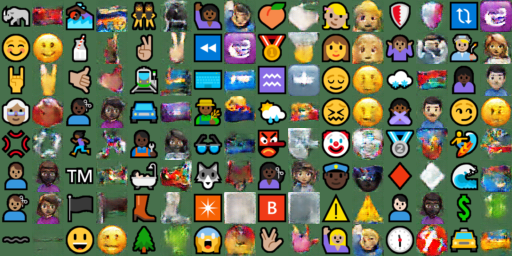

In [37]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-W-A'.format(n_iters) + '_no_cycle.png'))
image

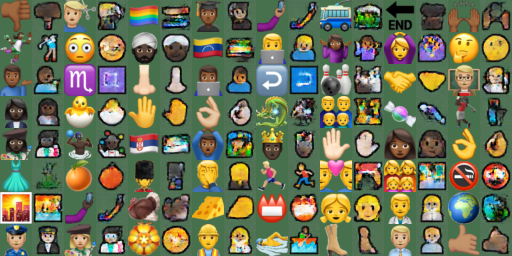

In [38]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-A-W'.format(n_iters) + '_no_cycle.png'))
image

# Wassesrstein Cycle GAN 

What we need to modify : 
1. Turning the Adam optimizer into the RMS Prop optimizer 
2. The discriminator should not end with a sigmoid on the last layer (this is ok) 
3. D_loss =  -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))


G_loss = -torch.mean(D_fake)

4. Clip parameters 

In [0]:
def training_loop_wass(M_train_loader, U_train_loader, M_test_loader, U_test_loader,
                       sample_every=1000,  lr=0.0002, train_iters=20000, log_step=10,
                       batch_size=64, use_cycle_consistency_loss=True, cyc_lambda=1,
                       opt_name=''):
    
    dict_result = {}
    dict_result['d_real_loss'] = []
    dict_result['d_loss_u'] = []
    dict_result['d_loss_m'] = []
    dict_result['d_fake_loss'] = []
    dict_result['g_loss'] = []
    dict_result['d_loss'] = []
    
    # Create generators and discriminators
    G_MtoU, G_UtoM, D_M, D_U = create_model()

    g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
    d_m_params = list(D_M.parameters())  # Get discriminator parameters
    d_u_params = list(D_U.parameters())  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = optim.RMSprop(g_params, lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    d_m_optimizer = optim.RMSprop(d_m_params, lr, alpha=0.99, eps=1e-08,
                                  weight_decay=0, momentum=0, centered=False)
    d_u_optimizer = optim.RMSprop(d_u_params, lr, alpha=0.99, eps=1e-08,
                                  weight_decay=0, momentum=0, centered=False)

    iter_M = iter(M_train_loader)
    iter_U = iter(U_train_loader)

    test_iter_M = iter(M_test_loader)
    test_iter_U = iter(U_test_loader)

    fixed_M = to_var(test_iter_M.next()[0])
    fixed_U = to_var(test_iter_U.next()[0])

    iter_per_epoch = min(len(iter_M), len(iter_U))

    for iteration in range(1, train_iters+1):

        # Reset data_iter for each epoch
        if iteration % iter_per_epoch == 0:
            iter_M = iter(M_train_loader)
            iter_U = iter(U_train_loader)

        images_M, labels_M = iter_M.next()
        images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

        images_U, labels_U = iter_U.next()
        images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # train the discriminator Diters times
        if iteration < 25 or iteration % 500 == 0:
            Diters = 100
        else:
            Diters = 5


        for _ in range(Diters):

            # Train with real images
            d_m_optimizer.zero_grad()
            d_u_optimizer.zero_grad()
            

            # Compute the discriminator losses on real images
            out_M = D_M(images_M) # discriminator mnist true
            d_real_loss_m = - torch.mean(out_M) 

            out_U = D_U(images_U)
            d_real_loss_u = - torch.mean(out_U)

            d_real_loss = d_real_loss_m + d_real_loss_u


            # Generate fake images that look like domain MNIST based on real images in domain USPS
            fake_M = G_UtoM(images_U)

            # Compute the loss for D_M
            out_M = D_M(fake_M)
            d_fake_loss_m =  torch.mean(out_M) 

            # 4. Generate fake images that look like domain U based on real images in domain M
            fake_U = G_MtoU(images_M)

            # 5. Compute the loss for D_U
            out_U = D_U(fake_U)
            d_fake_loss_u = torch.mean(out_U) 

            d_fake_loss = d_fake_loss_m + d_fake_loss_u


            # Total Discriminator Loss
            d_loss = d_real_loss + d_fake_loss

            # Discriminator Loss on MNIST and USPS
            d_loss_m = d_real_loss_m + d_fake_loss_m
            d_loss_u = d_real_loss_u + d_fake_loss_u


            d_loss_u.backward()
            d_loss_m.backward()

            d_m_optimizer.step()
            d_u_optimizer.step()


            # Clipping MNIST Discriminator's parameters 
            for p in D_M.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            # Clipping USPS Discriminator's parameters 
            for p in D_U.parameters():
                p.data.clamp_(-0.01, 0.01)



        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        g_optimizer.zero_grad()

        ## USPS--MNIST-->USPS 
        # Generate fake images that look like domain M based on real images in domain U
        fake_M = G_UtoM(images_U)
        out = D_M(fake_M)

        # Compute the generator loss based on domain M
        g_loss = - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_U = G_MtoU(fake_M)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
            g_loss += cyc_lambda * cycle_consistency_loss



        ## MNIST--USPS-->MNIST 
        # Generate fake images that look like domain U based on real images in domain M
        fake_U = G_MtoU(images_M)
        out = D_U(fake_U)

        # Compute the generator loss based on domain U
        g_loss += - torch.mean(out)

        if use_cycle_consistency_loss:
            reconstructed_M = G_UtoM(fake_U)
            # Compute the cycle consistency loss (the reconstruction loss)
            cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
            g_loss += cyc_lambda * cycle_consistency_loss



        g_loss.backward()
        g_optimizer.step()



        # Print the log info
        if iteration % log_step == 0:
            print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    iteration, train_iters, d_real_loss.item(), d_loss_u.item(),
                    d_loss_m.item(), d_fake_loss.item(), g_loss.item()))
            
        dict_result['d_real_loss'].append(float(to_data(d_real_loss)))
        dict_result['d_loss_u'].append(float(to_data(d_loss_u)))
        dict_result['d_loss_m'].append(float(to_data(d_loss_m)))
        dict_result['d_fake_loss'].append(float(to_data(d_fake_loss)))
        dict_result['g_loss'].append(float(to_data(g_loss)))
        dict_result['d_loss'].append(float(to_data(d_loss)))
        


        # Save the generated samples
        if iteration % sample_every == 0:
            save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU, opt_name=opt_name)

    return dict_result

In [40]:
APPLE_WIN_wass = training_loop_wass(dataloader_apple, dataloader_win, dataloader_apple_test, dataloader_win_test,
                                     sample_every=1000,  lr=0.0002, train_iters=n_iters, log_step=100,
                                     use_cycle_consistency_loss=True, opt_name='_wass')

                 G_AtoW                
---------------------------------------
G_(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Iteration [ 1000/10000] | d_real_loss: -1.1355 | d_U_loss: -0.1367 | d_M_loss: -0.1371 | d_fake_loss: 0.8617 | g_loss: -0.8133
Saved ./results/sample-001000-A-W_wass.png
Saved ./results/sample-001000-W-A_wass.png
Iteration [ 1100/10000] | d_real_loss: -1.0588 | d_U_loss: -0.0892 | d_M_loss: -0.0865 | d_fake_loss: 0.8831 | g_loss: -0.8922
Iteration [ 1200/10000] | d_real_loss: -1.1124 | d_U_loss: -0.0923 | d_M_loss: -0.0900 | d_fake_loss: 0.9302 | g_loss: -0.8418
Iteration [ 1300/10000] | d_real_loss: -1.0860 | d_U_loss: -0.0873 | d_M_loss: -0.0787 | d_fake_loss: 0.9200 | g_loss: -0.8616
Iteration [ 1400/10000] | d_real_loss: -1.0812 | d_U_loss: -0.0824 | d_M_loss: -0.0794 | d_fake_loss: 0.9193 | g_loss: -0.8714
Iteration [ 1500/10000] | d_real_loss: -1.1426 | d_U_loss: -0.1388 | d_M_loss: -0.1377 | d_fake_loss: 0.8661 | g_loss: -0.8167
Iteration [ 1600/10000] | d_real_loss: -1.0889 | d_U_loss: -0.0947 | d_M_loss: -0.0863 | d_fake_loss: 0.9079 | g_loss: -0.8665
Iteration [ 1700/10000] |

Iteration [ 2000/10000] | d_real_loss: -1.1450 | d_U_loss: -0.1383 | d_M_loss: -0.1341 | d_fake_loss: 0.8725 | g_loss: -0.8148
Saved ./results/sample-002000-A-W_wass.png
Saved ./results/sample-002000-W-A_wass.png
Iteration [ 2100/10000] | d_real_loss: -1.1174 | d_U_loss: -0.0949 | d_M_loss: -0.0857 | d_fake_loss: 0.9368 | g_loss: -0.8264
Iteration [ 2200/10000] | d_real_loss: -1.0859 | d_U_loss: -0.0889 | d_M_loss: -0.0806 | d_fake_loss: 0.9165 | g_loss: -0.8716
Iteration [ 2300/10000] | d_real_loss: -1.0873 | d_U_loss: -0.0784 | d_M_loss: -0.0844 | d_fake_loss: 0.9246 | g_loss: -0.8742
Iteration [ 2400/10000] | d_real_loss: -1.0630 | d_U_loss: -0.0921 | d_M_loss: -0.0755 | d_fake_loss: 0.8955 | g_loss: -0.9012
Iteration [ 2500/10000] | d_real_loss: -1.1437 | d_U_loss: -0.1437 | d_M_loss: -0.1399 | d_fake_loss: 0.8601 | g_loss: -0.8191
Iteration [ 2600/10000] | d_real_loss: -1.0695 | d_U_loss: -0.0828 | d_M_loss: -0.0821 | d_fake_loss: 0.9046 | g_loss: -0.8757
Iteration [ 2700/10000] |

Iteration [ 3000/10000] | d_real_loss: -1.1410 | d_U_loss: -0.1418 | d_M_loss: -0.1408 | d_fake_loss: 0.8583 | g_loss: -0.8233
Saved ./results/sample-003000-A-W_wass.png
Saved ./results/sample-003000-W-A_wass.png
Iteration [ 3100/10000] | d_real_loss: -1.1092 | d_U_loss: -0.0836 | d_M_loss: -0.0710 | d_fake_loss: 0.9545 | g_loss: -0.8525
Iteration [ 3200/10000] | d_real_loss: -1.0999 | d_U_loss: -0.0950 | d_M_loss: -0.0912 | d_fake_loss: 0.9136 | g_loss: -0.8569
Iteration [ 3300/10000] | d_real_loss: -1.0757 | d_U_loss: -0.0927 | d_M_loss: -0.0763 | d_fake_loss: 0.9067 | g_loss: -0.8859
Iteration [ 3400/10000] | d_real_loss: -1.0824 | d_U_loss: -0.0801 | d_M_loss: -0.0731 | d_fake_loss: 0.9292 | g_loss: -0.8834
Iteration [ 3500/10000] | d_real_loss: -1.1393 | d_U_loss: -0.1432 | d_M_loss: -0.1364 | d_fake_loss: 0.8598 | g_loss: -0.8295
Iteration [ 3600/10000] | d_real_loss: -1.0697 | d_U_loss: -0.0913 | d_M_loss: -0.0831 | d_fake_loss: 0.8953 | g_loss: -0.9048
Iteration [ 3700/10000] |

Iteration [ 4000/10000] | d_real_loss: -1.1400 | d_U_loss: -0.1412 | d_M_loss: -0.1395 | d_fake_loss: 0.8592 | g_loss: -0.8241
Saved ./results/sample-004000-A-W_wass.png
Saved ./results/sample-004000-W-A_wass.png
Iteration [ 4100/10000] | d_real_loss: -1.0778 | d_U_loss: -0.0870 | d_M_loss: -0.0803 | d_fake_loss: 0.9104 | g_loss: -0.8833
Iteration [ 4200/10000] | d_real_loss: -1.0855 | d_U_loss: -0.0864 | d_M_loss: -0.0824 | d_fake_loss: 0.9166 | g_loss: -0.8823
Iteration [ 4300/10000] | d_real_loss: -1.0774 | d_U_loss: -0.0815 | d_M_loss: -0.0794 | d_fake_loss: 0.9164 | g_loss: -0.8794
Iteration [ 4400/10000] | d_real_loss: -1.1064 | d_U_loss: -0.0828 | d_M_loss: -0.0741 | d_fake_loss: 0.9495 | g_loss: -0.8519
Iteration [ 4500/10000] | d_real_loss: -1.1430 | d_U_loss: -0.1421 | d_M_loss: -0.1383 | d_fake_loss: 0.8627 | g_loss: -0.8279
Iteration [ 4600/10000] | d_real_loss: -1.0570 | d_U_loss: -0.0749 | d_M_loss: -0.0749 | d_fake_loss: 0.9072 | g_loss: -0.9056
Iteration [ 4700/10000] |

Iteration [ 5000/10000] | d_real_loss: -1.1422 | d_U_loss: -0.1415 | d_M_loss: -0.1405 | d_fake_loss: 0.8601 | g_loss: -0.8291
Saved ./results/sample-005000-A-W_wass.png
Saved ./results/sample-005000-W-A_wass.png
Iteration [ 5100/10000] | d_real_loss: -1.0839 | d_U_loss: -0.0809 | d_M_loss: -0.0769 | d_fake_loss: 0.9262 | g_loss: -0.8790
Iteration [ 5200/10000] | d_real_loss: -1.0788 | d_U_loss: -0.0737 | d_M_loss: -0.0775 | d_fake_loss: 0.9276 | g_loss: -0.8859
Iteration [ 5300/10000] | d_real_loss: -1.0840 | d_U_loss: -0.0804 | d_M_loss: -0.0691 | d_fake_loss: 0.9344 | g_loss: -0.8867
Iteration [ 5400/10000] | d_real_loss: -1.0507 | d_U_loss: -0.0880 | d_M_loss: -0.0745 | d_fake_loss: 0.8881 | g_loss: -0.9243
Iteration [ 5500/10000] | d_real_loss: -1.1427 | d_U_loss: -0.1392 | d_M_loss: -0.1405 | d_fake_loss: 0.8630 | g_loss: -0.8298
Iteration [ 5600/10000] | d_real_loss: -1.0806 | d_U_loss: -0.0895 | d_M_loss: -0.0823 | d_fake_loss: 0.9088 | g_loss: -0.8878
Iteration [ 5700/10000] |

Iteration [ 6000/10000] | d_real_loss: -1.1394 | d_U_loss: -0.1376 | d_M_loss: -0.1398 | d_fake_loss: 0.8620 | g_loss: -0.8283
Saved ./results/sample-006000-A-W_wass.png
Saved ./results/sample-006000-W-A_wass.png
Iteration [ 6100/10000] | d_real_loss: -1.0533 | d_U_loss: -0.0789 | d_M_loss: -0.0787 | d_fake_loss: 0.8958 | g_loss: -0.9201
Iteration [ 6200/10000] | d_real_loss: -1.1082 | d_U_loss: -0.0824 | d_M_loss: -0.0810 | d_fake_loss: 0.9448 | g_loss: -0.8582
Iteration [ 6300/10000] | d_real_loss: -1.0867 | d_U_loss: -0.0839 | d_M_loss: -0.0741 | d_fake_loss: 0.9288 | g_loss: -0.8789
Iteration [ 6400/10000] | d_real_loss: -1.1049 | d_U_loss: -0.0854 | d_M_loss: -0.0800 | d_fake_loss: 0.9395 | g_loss: -0.8596
Iteration [ 6500/10000] | d_real_loss: -1.1445 | d_U_loss: -0.1412 | d_M_loss: -0.1335 | d_fake_loss: 0.8698 | g_loss: -0.8291
Iteration [ 6600/10000] | d_real_loss: -1.0763 | d_U_loss: -0.0831 | d_M_loss: -0.0726 | d_fake_loss: 0.9207 | g_loss: -0.8943
Iteration [ 6700/10000] |

Iteration [ 7000/10000] | d_real_loss: -1.1365 | d_U_loss: -0.1373 | d_M_loss: -0.1378 | d_fake_loss: 0.8613 | g_loss: -0.8356
Saved ./results/sample-007000-A-W_wass.png
Saved ./results/sample-007000-W-A_wass.png
Iteration [ 7100/10000] | d_real_loss: -1.0663 | d_U_loss: -0.0854 | d_M_loss: -0.0762 | d_fake_loss: 0.9048 | g_loss: -0.9163
Iteration [ 7200/10000] | d_real_loss: -1.0751 | d_U_loss: -0.0773 | d_M_loss: -0.0739 | d_fake_loss: 0.9239 | g_loss: -0.8940
Iteration [ 7300/10000] | d_real_loss: -1.1092 | d_U_loss: -0.0947 | d_M_loss: -0.0706 | d_fake_loss: 0.9439 | g_loss: -0.8536
Iteration [ 7400/10000] | d_real_loss: -1.0816 | d_U_loss: -0.0867 | d_M_loss: -0.0749 | d_fake_loss: 0.9200 | g_loss: -0.9024
Iteration [ 7500/10000] | d_real_loss: -1.1449 | d_U_loss: -0.1416 | d_M_loss: -0.1347 | d_fake_loss: 0.8687 | g_loss: -0.8281
Iteration [ 7600/10000] | d_real_loss: -1.0820 | d_U_loss: -0.0859 | d_M_loss: -0.0719 | d_fake_loss: 0.9242 | g_loss: -0.8831
Iteration [ 7700/10000] |

Iteration [ 8000/10000] | d_real_loss: -1.1342 | d_U_loss: -0.1392 | d_M_loss: -0.1368 | d_fake_loss: 0.8582 | g_loss: -0.8423
Saved ./results/sample-008000-A-W_wass.png
Saved ./results/sample-008000-W-A_wass.png
Iteration [ 8100/10000] | d_real_loss: -1.0851 | d_U_loss: -0.0788 | d_M_loss: -0.0785 | d_fake_loss: 0.9278 | g_loss: -0.9000
Iteration [ 8200/10000] | d_real_loss: -1.0821 | d_U_loss: -0.0866 | d_M_loss: -0.0749 | d_fake_loss: 0.9206 | g_loss: -0.8923
Iteration [ 8300/10000] | d_real_loss: -1.0535 | d_U_loss: -0.0824 | d_M_loss: -0.0748 | d_fake_loss: 0.8962 | g_loss: -0.9258
Iteration [ 8400/10000] | d_real_loss: -1.1020 | d_U_loss: -0.0759 | d_M_loss: -0.0796 | d_fake_loss: 0.9464 | g_loss: -0.8715
Iteration [ 8500/10000] | d_real_loss: -1.1386 | d_U_loss: -0.1364 | d_M_loss: -0.1373 | d_fake_loss: 0.8648 | g_loss: -0.8370
Iteration [ 8600/10000] | d_real_loss: -1.0464 | d_U_loss: -0.0726 | d_M_loss: -0.0798 | d_fake_loss: 0.8941 | g_loss: -0.9232
Iteration [ 8700/10000] |

Iteration [ 9000/10000] | d_real_loss: -1.1454 | d_U_loss: -0.1424 | d_M_loss: -0.1403 | d_fake_loss: 0.8626 | g_loss: -0.8289
Saved ./results/sample-009000-A-W_wass.png
Saved ./results/sample-009000-W-A_wass.png
Iteration [ 9100/10000] | d_real_loss: -1.0669 | d_U_loss: -0.0864 | d_M_loss: -0.0808 | d_fake_loss: 0.8997 | g_loss: -0.9185
Iteration [ 9200/10000] | d_real_loss: -1.0891 | d_U_loss: -0.0756 | d_M_loss: -0.0812 | d_fake_loss: 0.9324 | g_loss: -0.8857
Iteration [ 9300/10000] | d_real_loss: -1.0821 | d_U_loss: -0.0732 | d_M_loss: -0.0734 | d_fake_loss: 0.9355 | g_loss: -0.8900
Iteration [ 9400/10000] | d_real_loss: -1.0493 | d_U_loss: -0.0820 | d_M_loss: -0.0691 | d_fake_loss: 0.8982 | g_loss: -0.9367
Iteration [ 9500/10000] | d_real_loss: -1.1450 | d_U_loss: -0.1438 | d_M_loss: -0.1432 | d_fake_loss: 0.8579 | g_loss: -0.8263
Iteration [ 9600/10000] | d_real_loss: -1.1005 | d_U_loss: -0.0789 | d_M_loss: -0.0894 | d_fake_loss: 0.9321 | g_loss: -0.8674
Iteration [ 9700/10000] |

Iteration [10000/10000] | d_real_loss: -1.1494 | d_U_loss: -0.1438 | d_M_loss: -0.1416 | d_fake_loss: 0.8640 | g_loss: -0.8294
Saved ./results/sample-010000-A-W_wass.png
Saved ./results/sample-010000-W-A_wass.png


Résults :

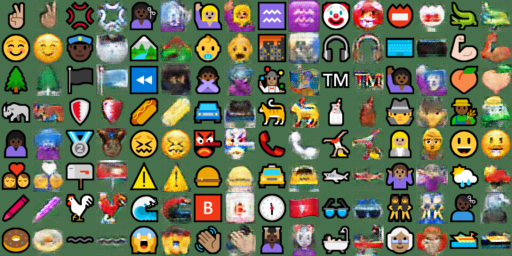

In [41]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-W-A'.format(n_iters) + '_wass.png'))
image

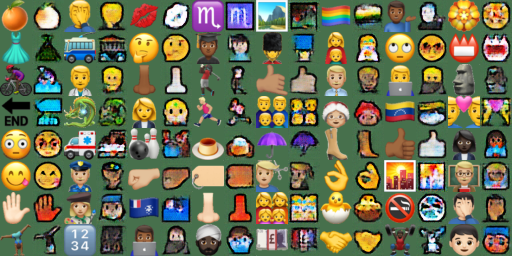

In [42]:
from PIL import Image
image = Image.open(os.path.join(RESULTS_PATH, 'sample-{:06d}-A-W'.format(n_iters) + '_wass.png'))
image

# Loss analysis

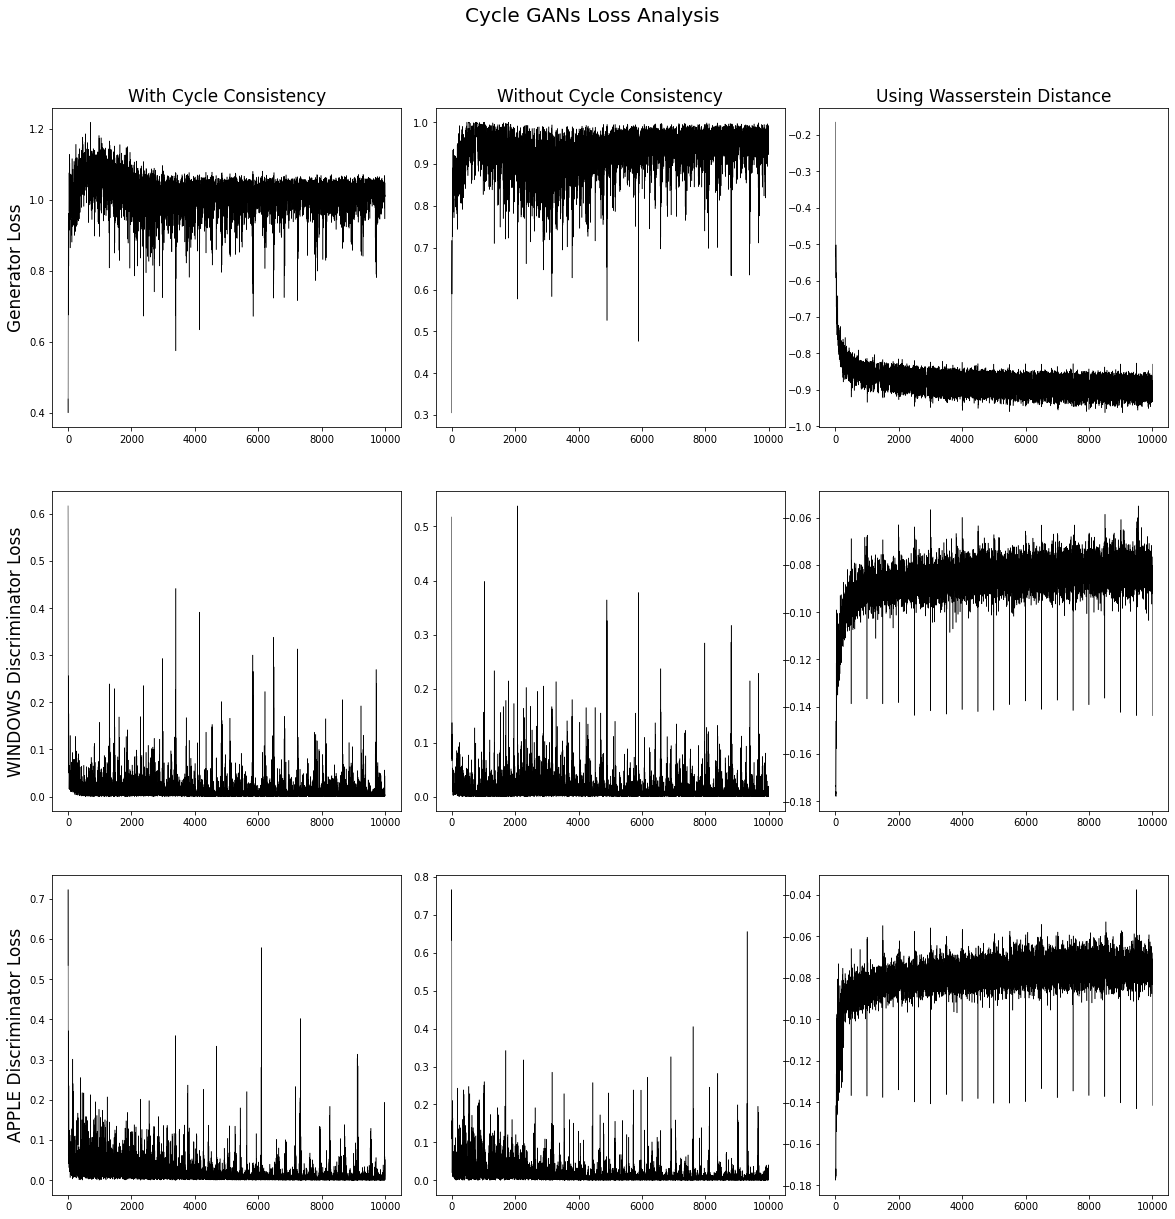

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

axes[0,0].plot(APPLE_WIN['g_loss'], color='black', linewidth=0.5)
axes[0,0].set_title('With Cycle Consistency', fontsize=17)
axes[0,0].set_ylabel("Generator Loss", fontsize=17)
axes[0,1].plot(APPLE_WIN_no_cycle['g_loss'], color='black', linewidth=0.5)
axes[0,1].set_title('Without Cycle Consistency', fontsize=17)
axes[0,2].plot(APPLE_WIN_wass['g_loss'], color='black', linewidth=0.5)
axes[0,2].set_title('Using Wasserstein Distance', fontsize=17)

axes[1,0].plot(APPLE_WIN['D_W_loss'], color='black', linewidth=0.5)
axes[1,0].set_ylabel("WINDOWS Discriminator Loss", fontsize=17)
axes[1,1].plot(APPLE_WIN_no_cycle['D_W_loss'], color='black', linewidth=0.5)
axes[1,2].plot(APPLE_WIN_wass['d_loss_u'], color='black', linewidth=0.5)

axes[2,0].plot(APPLE_WIN['D_A_loss'], color='black', linewidth=0.5)
axes[2,0].set_ylabel("APPLE Discriminator Loss", fontsize=17)
axes[2,1].plot(APPLE_WIN_no_cycle['D_A_loss'], color='black', linewidth=0.5)
axes[2,2].plot(APPLE_WIN_wass['d_loss_m'], color='black', linewidth=0.5)

fig.suptitle('Cycle GANs Loss Analysis', fontsize=20, y=0.95)
fig.subplots_adjust(wspace=0.1)

plt.savefig(os.path.join(RESULTS_PATH, 'loss_analysis.jpg'), optimize=True, quality=95)
plt.show()